<a href="https://colab.research.google.com/github/VavRe/nlp-ut/blob/main/CA3/Q1_Twitter_Sentiment_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2023-05-14 19:26:47--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-05-14 19:26:47--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  39.3MB/s    in 2.0s    

2023-05-14 19:26:49 (39.3 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, LSTM
from keras.models import Sequential


#Preprocessing

In [4]:
columns = ["sentiment","id","datetime","query","user","tweet"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin-1", names=columns)

In [5]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [6]:
df = df.loc[:,["sentiment","tweet"]]
df

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
from sklearn.model_selection import train_test_split

samples_fraction = 0.08
stratify_on = "sentiment"

_, dataset = train_test_split(df, stratify=df[stratify_on], 
                                 test_size=samples_fraction,
                                 random_state=76)

# Reset the index of the sampled DataFrame
dataset.reset_index(drop=True, inplace=True)


In [8]:
dataset["sentiment"].value_counts()

0    64000
4    64000
Name: sentiment, dtype: int64

In [9]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess_tweet(tweet, remove_stopwords=True, stem_words=True, handle_negation=True):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs, mentions, and hashtags
    tweet = re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#\w+", "", tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove stopwords 
    if remove_stopwords:
        tweet_tokens = tweet.split()
        tweet = " ".join([word for word in tweet_tokens if word not in stop_words])
    
    # Stem words 
    if stem_words:
        stemmer = PorterStemmer()
        tweet_tokens = tweet.split()
        tweet = " ".join([stemmer.stem(word) for word in tweet_tokens])
        
    # Handle negation 
    if handle_negation:
        tweet_tokens = word_tokenize(tweet)
        negation_flag = False
        negated_tokens = []
        for i, token in enumerate(tweet_tokens):
            if token in ["not", "n't", "no"]:
                negation_flag = True
            elif negation_flag:
                negated_tokens.append("not_" + token)
                negation_flag = False
            else:
                negated_tokens.append(token)
        tweet = " ".join(negated_tokens)
    
    return tweet


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
from tqdm import tqdm
tqdm.pandas()


dataset["tweet"] = dataset["tweet"].progress_apply(preprocess_tweet)

100%|██████████| 128000/128000 [00:36<00:00, 3529.73it/s]


In [11]:
from keras.utils import to_categorical
X = dataset["tweet"]
y = dataset["sentiment"]

In [12]:
y = y.replace(4,1)
y = y.replace(4,1)

In [13]:
import gc

del df
gc.collect() # collect garbage 

0

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [15]:
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [16]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
# Pad the sequences to a fixed length
max_length = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


# GloVe LSTM

## Process and Train

In [18]:
!pip install kaggle ;
!mkdir ~/.kaggle/ ;
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ ;
!chmod 600 ~/.kaggle/kaggle.json ;
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!unzip  /content/glove-global-vectors-for-word-representation.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 94% 429M/458M [00:01<00:00, 354MB/s]
100% 458M/458M [00:01<00:00, 315MB/s]
Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [19]:
# # Use one-hot vectors for one option
# X_train_onehot = tokenizer.sequences_to_matrix(X_train_seq, mode='binary')
# X_test_onehot = tokenizer.sequences_to_matrix(X_test_seq, mode='binary')

# Use GloVe embeddings for another option
glove_embeddings_index = {}
with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs
embedding_dim = 200
glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector


In [20]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)


LSTM_glove = Sequential()
LSTM_glove.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[glove_embedding_matrix], trainable=False))
LSTM_glove.add(CuDNNLSTM(150))
LSTM_glove.add(Dropout(0.2))
LSTM_glove.add(Dense(2, activation='softmax'))
LSTM_glove.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = LSTM_glove.fit(X_train_pad, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.6986
Epoch 1: val_loss improved from inf to 0.53562, saving model to my_best_model.hdf5
320/320 [==============================] - 20s 32ms/step - loss: 0.5752 - accuracy: 0.6986 - val_loss: 0.5356 - val_accuracy: 0.7314
Epoch 2/100
319/320 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.7440
Epoch 2: val_loss improved from 0.53562 to 0.52035, saving model to my_best_model.hdf5
320/320 [==============================] - 9s 30ms/step - loss: 0.5150 - accuracy: 0.7440 - val_loss: 0.5203 - val_accuracy: 0.7391
Epoch 3/100
318/320 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.7619
Epoch 3: val_loss improved from 0.52035 to 0.51911, saving model to my_best_model.hdf5
320/320 [==============================] - 8s 24ms/step - loss: 0.4893 - accuracy: 0.7619 - val_loss: 0.5191 - val_accuracy: 0.7417
Epoch 4/100
319/320 [============================>.] - 

## Results

In [21]:
y_pred = LSTM_glove.predict(X_test_pad)

800/800 [==============================] - 3s 3ms/step


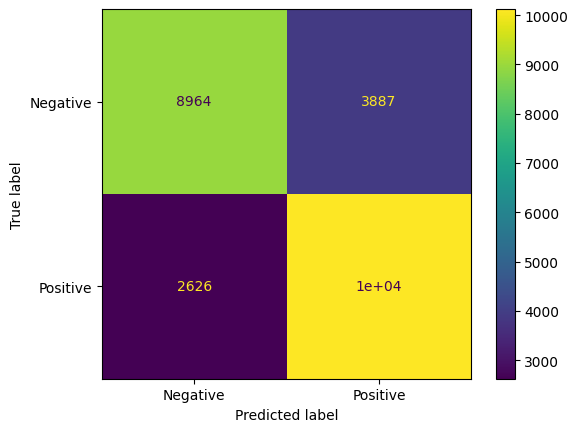

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [23]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.77      0.70      0.73     12851
    Positive       0.72      0.79      0.76     12749

    accuracy                           0.75     25600
   macro avg       0.75      0.75      0.75     25600
weighted avg       0.75      0.75      0.75     25600



# Word2Vec LSTM

## Process and Train

In [24]:
tqdm.pandas()
dataset["tokenized"] = dataset["tweet"].progress_apply(word_tokenize)

100%|██████████| 128000/128000 [00:11<00:00, 11108.01it/s]


In [25]:
dataset["tokenized"]

0                                              [woke, work]
1           [feel, like, im, person, world, work, saturday]
2         [ill, call, u, want, tell, twitter, mi, biz, lol]
3         [need, get, comic, final, get, back, printer, ...
4         [think, coz, ask, late, lol, like, fair, argum...
                                ...                        
127995    [omg, slip, stair, hous, hurt, im, even, drunk...
127996    [someon, pleas, open, decent, cafe, trawalla, ...
127997                              [comput, problem, byte]
127998    [surround, shiraz, univers, took, student, kno...
127999    [lot, agenda, today, studi, blog, updat, featu...
Name: tokenized, Length: 128000, dtype: object

In [26]:
import gensim
from gensim.models import Word2Vec


w2v_model = Word2Vec(dataset["tokenized"].to_numpy(), vector_size=embedding_dim, window=5, min_count=1, workers=4)


In [27]:
w2v_embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    try: 
        embedding_vector = w2v_model.wv.get_vector(word)
    except KeyError:
        print(f"the word {word} is not available")
    if embedding_vector is not None:
        w2v_embedding_matrix[i] = embedding_vector


the word not is not available
the word o is not available
the word t is not available
the word the is not available
the word s is not available


In [28]:
filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)


LSTM_w2v = Sequential()
LSTM_w2v.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[w2v_embedding_matrix], trainable=False))
LSTM_w2v.add(CuDNNLSTM(150))
LSTM_w2v.add(Dropout(0.2))
LSTM_w2v.add(Dense(2, activation='softmax'))
LSTM_w2v.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = LSTM_w2v.fit(X_train_pad, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.7156
Epoch 1: val_loss improved from inf to 0.51714, saving model to my_best_model.hdf5
320/320 [==============================] - 10s 28ms/step - loss: 0.5537 - accuracy: 0.7156 - val_loss: 0.5171 - val_accuracy: 0.7407
Epoch 2/100
319/320 [============================>.] - ETA: 0s - loss: 0.5160 - accuracy: 0.7425
Epoch 2: val_loss improved from 0.51714 to 0.50837, saving model to my_best_model.hdf5
320/320 [==============================] - 9s 28ms/step - loss: 0.5160 - accuracy: 0.7425 - val_loss: 0.5084 - val_accuracy: 0.7462
Epoch 3/100
318/320 [============================>.] - ETA: 0s - loss: 0.5073 - accuracy: 0.7487
Epoch 3: val_loss did not improve from 0.50837
320/320 [==============================] - 9s 27ms/step - loss: 0.5072 - accuracy: 0.7488 - val_loss: 0.5111 - val_accuracy: 0.7429
Epoch 4/100
319/320 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.751

In [29]:
y_pred = LSTM_w2v.predict(X_test_pad)

800/800 [==============================] - 3s 3ms/step


## Results

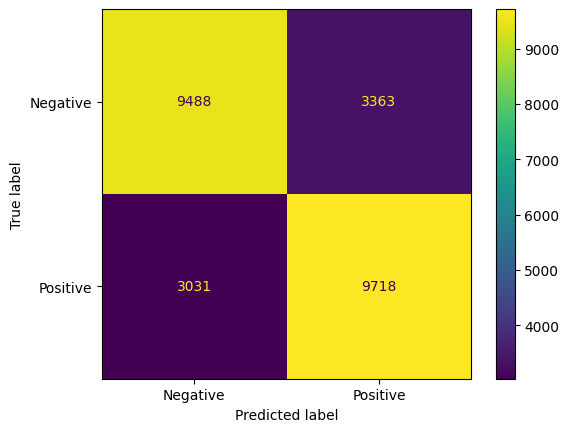

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [31]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.76      0.74      0.75     12851
    Positive       0.74      0.76      0.75     12749

    accuracy                           0.75     25600
   macro avg       0.75      0.75      0.75     25600
weighted avg       0.75      0.75      0.75     25600



#One-Hot LSTM

## Process and Train

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a sample text data

# Initialize the CountVectorizer
vectorizer = CountVectorizer(binary=True, max_features=5000 )

# Fit the vectorizer to the text data
vectorizer.fit(X_train)

# # Transform the text data into a one-hot encoded matrix
X_train_onehot = vectorizer.transform(X_train).toarray()
X_test_onehot = vectorizer.transform(X_test).toarray()

# Print the one-hot encoded data
# type(X_train_onehot)

In [33]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout,Reshape
import tensorflow as tf

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
timesteps = 1
vocab_size = 5000
input_shape = (vocab_size,)

LSTM_onehot = Sequential()
LSTM_onehot.add(Dense(units=150, activation='relu', input_shape=input_shape))
LSTM_onehot.add(Reshape((1, 150)))
LSTM_onehot.add(CuDNNLSTM(150))
LSTM_onehot.add(Dropout(0.2))
LSTM_onehot.add(Dense(2, activation='softmax'))
LSTM_onehot.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = LSTM_onehot.fit(X_train_onehot, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
2549/2560 [============================>.] - ETA: 0s - loss: 0.5285 - accuracy: 0.7404
Epoch 1: val_loss improved from inf to 0.51540, saving model to my_best_model.hdf5
2560/2560 [==============================] - 16s 6ms/step - loss: 0.5283 - accuracy: 0.7405 - val_loss: 0.5154 - val_accuracy: 0.7503
Epoch 2/100
2559/2560 [============================>.] - ETA: 0s - loss: 0.4448 - accuracy: 0.7899
Epoch 2: val_loss did not improve from 0.51540
2560/2560 [==============================] - 13s 5ms/step - loss: 0.4447 - accuracy: 0.7899 - val_loss: 0.5201 - val_accuracy: 0.7563
Epoch 3/100
2556/2560 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8422
Epoch 3: val_loss did not improve from 0.51540
2560/2560 [==============================] - 14s 5ms/step - loss: 0.3462 - accuracy: 0.8421 - val_loss: 0.5733 - val_accuracy: 0.7491
Epoch 4/100
2557/2560 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.8971
Epoch 4: val_loss did not

In [34]:
y_pred = LSTM_onehot.predict(X_test_onehot)


800/800 [==============================] - 2s 2ms/step


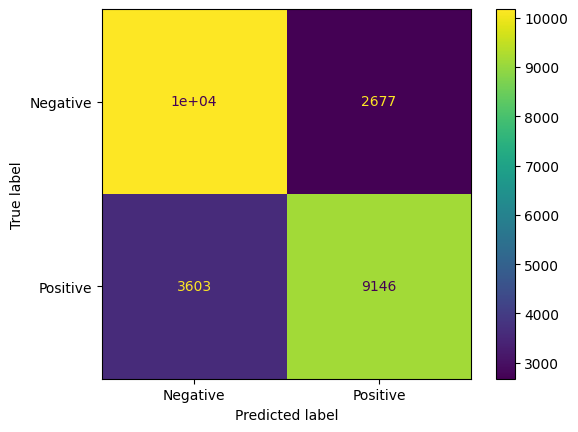

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [36]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))



              precision    recall  f1-score   support

    Negative       0.74      0.79      0.76     12851
    Positive       0.77      0.72      0.74     12749

    accuracy                           0.75     25600
   macro avg       0.76      0.75      0.75     25600
weighted avg       0.76      0.75      0.75     25600

